In [3]:
# Standards
import os
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# Image Processing Libraries
import cv2
import skimage.feature as feature
from skimage.feature import hog
from skimage.feature import CENSURE
from skimage import data, color, exposure, filters

# Feature Extractions
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import MiniBatchDictionaryLearning
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.feature_extraction.image import reconstruct_from_patches_2d

rseed=4444

%matplotlib inline


In [4]:
df_img = pd.read_pickle('df_img.pkl')

# Data Inventory

In [6]:
def seeImg(img):
    plt.figure(figsize=)
    plt.imshow(img, aspect='auto')
    plt.grid(False)
    plt.axis('off')

In [ ]:
def seeActualVsHog(img, hog):    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

    ax1.axis('off')
    ax1.imshow(img, cmap=plt.cm.gray, aspect='auto')
    ax1.set_title('Input image')
    ax1.set_adjustable('box-forced')

    # Rescale histogram for better display
    hog_image_rescaled = exposure.rescale_intensity(hog, in_range=(0, 1))

    ax2.axis('off')
    ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray, aspect='auto')
    ax2.set_title('Histogram of Oriented Gradients')
    ax1.set_adjustable('box-forced')
    plt.show()

In [ ]:
df_img.head(2)

In [ ]:
# Top categories
print('Top Categories')
print('--------------')
for v in df_img['category'].value_counts().sort_values(ascending=False).index[:10]:
    print(v)

In [ ]:
mask = (df_img.category == 'airplanes') | (df_img.category == 'motorbikes')
df_mtrbk_arpln = df_img[mask]

# Image Processing Pipeline

In [ ]:
def img_pipeline(path, h=32, w=32):
    img = cv2.imread(path,0)
    if img is not None:
        return cv2.resize(img, (h,w), interpolation = cv2.INTER_CUBIC)
    else:
        return np.nan

In [ ]:
def getPixelFeatures(series):
    df_pxls = pd.DataFrame(series).dropna()
    
#     def changeToSeries(arr):
#         if type(arr) == np.ndarray:
#             return pd.Series(arr.flatten())
#         else:
#             return np.nan
        
    # expand column into its own dataframe
    df_pxls = df_pxls['img_path'].apply(lambda x: pd.Series(x.flatten()))
    #lambda x: pd.Series(x.flatten()) if type(x) is not float else np.nan)

    # rename each variable to a pixel
    df_pxls = df_pxls.rename(columns = lambda x : 'pxl_' + str(x))

    df_pxl_features = (pd
                       .merge(df_img, df_pxls, right_index=True, left_index=True)
                       .drop(['img_path', 'file_name'], axis=1))
    
    return df_pxl_features

# Application

In [ ]:
def picklePixelFeatures():
    cvtd_imgs = df_img.img_path.apply(img_pipeline)
    df_pxl_features = getPixelFeatures(cvtd_imgs)
    df_pxl_features.to_pickle('df_pxl_features.pkl')

In [ ]:
def pickleHOGFeatures():
    # convert images to 256 x 256
    images = df_img.img_path.apply(img_pipeline, args=(256,256)).dropna()
    
    # get the HOG features & store it into a DataFrame
    hog_features = [hog(img, orientations=8, pixels_per_cell=(16, 16), 
                          cells_per_block=(1, 1), transform_sqrt=True)
                        for img in images]
    
    df_hog_features = pd.DataFrame(hog_features, dtype='float32')
    
    # rename each variable to a hog
    df_hog_features = df_hog_features.rename(columns = lambda x : 'hog_' + str(x+1))
    
    # merge the tables then drop the unnecessary data
    df_hog_features = (pd
                       .merge(df_img, df_hog_features, right_index=True, left_index=True)
                       .drop(['img_path', 'file_name'], axis=1))
    
    df_hog_features.to_pickle('df_hog_features.pkl')

In [ ]:
def pickleORBFeatures():
    images = df_img.img_path.apply(img_pipeline, args=(256,256)).dropna()
    
    orb_features = [orb]

In [ ]:
images = df_img.img_path.apply(img_pipeline, args=(256,256)).dropna()

In [ ]:
img = images[2000]

/Users/gabrielruiz/anaconda/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


(-0.5, 1399.5, 786.5, -0.5)

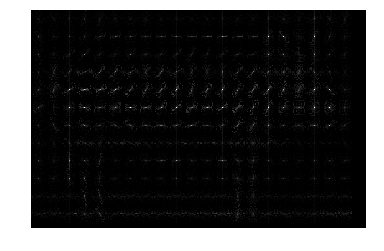

In [17]:
img = cv2.imread('./presentation/pig.jpg', 0)
# f1 = exposure.equalize_adapthist(img, clip_limit=0.03)
# f2 = filters.gaussian(f1, 1.2)
# f3 = filters.sobel(f2)
# canny = feature.canny(f3)
fd, hog_img = hog(img, orientations=25, pixels_per_cell=(64, 64), cells_per_block=(1, 1),
                       transform_sqrt=True,  visualise=True)

hog_image_rescaled = exposure.rescale_intensity(hog_img, in_range=(0, 0.2))
cv2.imwrite('pig-hog.jpg', hog_image_rescaled)


plt.figure()
plt.imshow(hog_image_rescaled, aspect='auto', cmap=plt.cm.gray)
plt.grid(False)
plt.axis('off');

In [ ]:
def seeKeypoints(detector, img):
#     print(np.sort(detector.keypoints[:, ::-1], axis=0))
    plt.imshow(img, cmap=plt.cm.gray)
    plt.scatter(detector.keypoints[:, 1], detector.keypoints[:, 0],
                  2 ** detector.scales, facecolors='none', edgecolors='r')
    plt.title("Original Image")
    plt.grid(False)

# SIFT Features

In [ ]:
columns = ['index', 'label', 'point', 'size', 'angle', 'response', 'octave', 'class_id']
dtypes =  {'index': 'int', 
           'label': 'object',
           'point': 'object',
           'size': 'float',
           'angle': 'float',
           'response': 'float',
           'octave': 'float',
           'class_id': 'int'}

for x in range(0,128):
    colname = 'des_'+str(x+1)
    columns.append(colname)
    dtypes[colname] = 'int16'

In [ ]:
df_sift_features = pd.DataFrame(columns=columns)
df_sift_features = df_sift_features.astype(dtypes)

In [ ]:
f = open('sift_features_resized.csv', 'a')

In [ ]:
sift = cv2.xfeatures2d.SIFT_create()

In [40]:
def drawSift(img):
    sift = cv2.xfeatures2d.SIFT_create()
    kp = sift.detect(img,None)
    sift_img=cv2.drawKeypoints(img,kp,img)
    cv2.imwrite("./presentation/sift_img.jpg", sift_img )
    
    fig, ax = plt.subplots()
    ax.axis('off')
    ax.imshow(sift_img)
    # descs_num = descs.shape[0] * descs.shape[1]
    # ax.set_title('%i DAISY descriptors extracted:' % descs_num)
    plt.show()

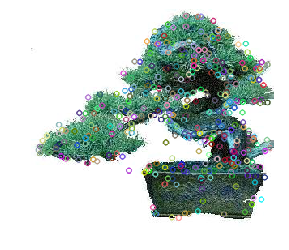

In [41]:
drawSift(img = cv2.imread(df_img.iloc[1927,0]))

In [ ]:
def sift_pipeline(path):
    global df_sift_features
    
    df = pd.DataFrame(columns=columns).astype(dtypes)
    data = {'index': path.name,
            'label': path.category}
    
    img_path = path.img_path
    img = cv2.imread(img_path,0)
    
    h=256
    w=256
    img = cv2.resize(img, (h,w), interpolation = cv2.INTER_CUBIC)
    
    if img is not None:
        kps, des = sift.detectAndCompute(img, None)
#         print(kps)
        try:
            for point in zip(des,kps):
                for ind,desc in enumerate(point[0]):
                    data['des_' + str(ind+1)] = np.int16(desc)
                
                data['point'] = [point[1].pt]
                data['size'] = point[1].size
                data['angle'] = point[1].angle
                data['response'] = point[1].response
                data['octave'] = point[1].octave
                data['class_id'] = point[1].class_id

                df = pd.concat([df, pd.DataFrame(data,columns=columns)])
            
            df.to_csv(f, header=False, index=False)
#             df_sift_features = pd.concat([df_sift_features, df])
        except Exception as e:
            print('Failed at index {0}'.format(path.name))
            print(e)
    else:
        return np.nan
    

In [ ]:
%time df_img.iloc[523:10000, :].apply(sift_pipeline, axis=1)
os.system('afplay /System/Library/Sounds/Sosumi.aiff')
os.system('say "Complete"')

In [ ]:
f.close()
del f

In [ ]:
with open('test.csv', 'r'):
    t1 = pd.read_csv('test.csv',header=None)

In [ ]:
df_img.iloc[10000:, :].apply(sift_pipeline, axis=1)
os.system('afplay /System/Library/Sounds/Sosumi.aiff')
os.system('say "Complete"')

In [ ]:
del df_sift_features

In [ ]:
with open('df_sift_features__5068-end.pkl', 'wb') as f:
    pickle.dump(df_sift_features, f)

In [ ]:
# cutest tree ever: images[1400]

In [ ]:

patch_size = (16, 16)

# img_patches = extract_patches_2d(img, patch_size)
# img_patches = data.reshape(data.shape[0], -1)

## Building Cluster

In [ ]:
# number of clusters / size of 'image model' / size of histogram
d = 200
kmeans = MiniBatchKMeans(n_clusters=d, random_state=rseed)

In [ ]:
kmeans.partial_fit(des)

In [ ]:
hist = []
for d in des:
    hist.append(kmeans.predict(d.reshape(1,-1)))    

In [ ]:
labels = kmeans.labels_.shape[0]
bins = np.arange(0, labels)
np.histogram(hist, bins=bins, range=(0,labels))

## Dictionary Building

In [ ]:
dico = MiniBatchDictionaryLearning(n_components=100,
                                   alpha=1,
                                   n_iter=50,
                                   random_state=rseed)

In [ ]:
%time dico.fit(data)